# Imoprting Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass
from typing import List, Callable


# Setting Up Indiviual Class

In [3]:
class Individual:
    def __init__(self, genome_length: int, rng: np.random.Generator):
        self.genome = rng.integers(0, 2, size=genome_length)
        self.fitness = None

    def copy(self):
        ind = Individual.__new__(Individual)
        ind.genome = self.genome.copy()
        ind.fitness = self.fitness
        return ind

# Fitness Functions

In [4]:
# Fitness Functions (MINIMIZATION: lower = better)
def onemax(ind):
    return np.sum(ind.genome)

def trap(ind):
    ones = np.sum(ind.genome)
    n = len(ind.genome)
    if ones == 0: return 0
    if ones == n: return n * 0.3
    return n - ones  # Gradient toward all-0s

def sphere(ind):
    s = np.sum(ind.genome)
    n = len(ind.genome)
    return (s - n/2) ** 2 / n  # Squared distance from middle

def rastrigin(ind):
    ones = np.sum(ind.genome)
    n = len(ind.genome)
    x = (ones / n - 0.5) * 10  # Map to [-5, 5]
    return 10 + x**2 - 10 * np.cos(2 * np.pi * x)

def royal_road(ind):
    genome = ind.genome
    n = len(genome)
    block_size = 4  # Check blocks of 4 bits

    # Count complete blocks of all-0s (good) or all-1s (deceptive)
    num_blocks = n // block_size
    zero_blocks = 0
    one_blocks = 0

    for i in range(num_blocks):
        block = genome[i*block_size:(i+1)*block_size]
        if np.all(block == 0):
            zero_blocks += 1
        elif np.all(block == 1):
            one_blocks += 1

    if zero_blocks == num_blocks:
        return 0

    if one_blocks == num_blocks:
        return block_size  # Not as good as global optimum

    mixed_penalty = (num_blocks - zero_blocks - one_blocks) * 10
    return n - (zero_blocks * block_size) + mixed_penalty


def massively_multimodal(ind):
    genome = ind.genome
    n = len(genome)

    ones = np.sum(genome)
    if ones == 0:
        comp1 = 0
    elif ones == n:
        comp1 = 20
    else:
        comp1 = n - ones + 10

    alternating_01 = sum([genome[i] != genome[i+1] for i in range(n-1)])
    comp2 = alternating_01 * 2

    block_size = 3
    num_blocks = n // block_size
    uniform_blocks = 0
    for i in range(num_blocks):
        block = genome[i*block_size:(i+1)*block_size]
        if len(np.unique(block)) == 1:
            if block[0] == 0:
                uniform_blocks += 0  # Good
            else:
                uniform_blocks += 3  # Deceptive
        else:
            uniform_blocks += 5  # Mixed is worst
    comp3 = uniform_blocks

    comp4 = sum([genome[i] * (i % 7 + 1) for i in range(n)]) / n

    return comp1 + comp2 + comp3 + comp4


# Visualizating Fitness functions

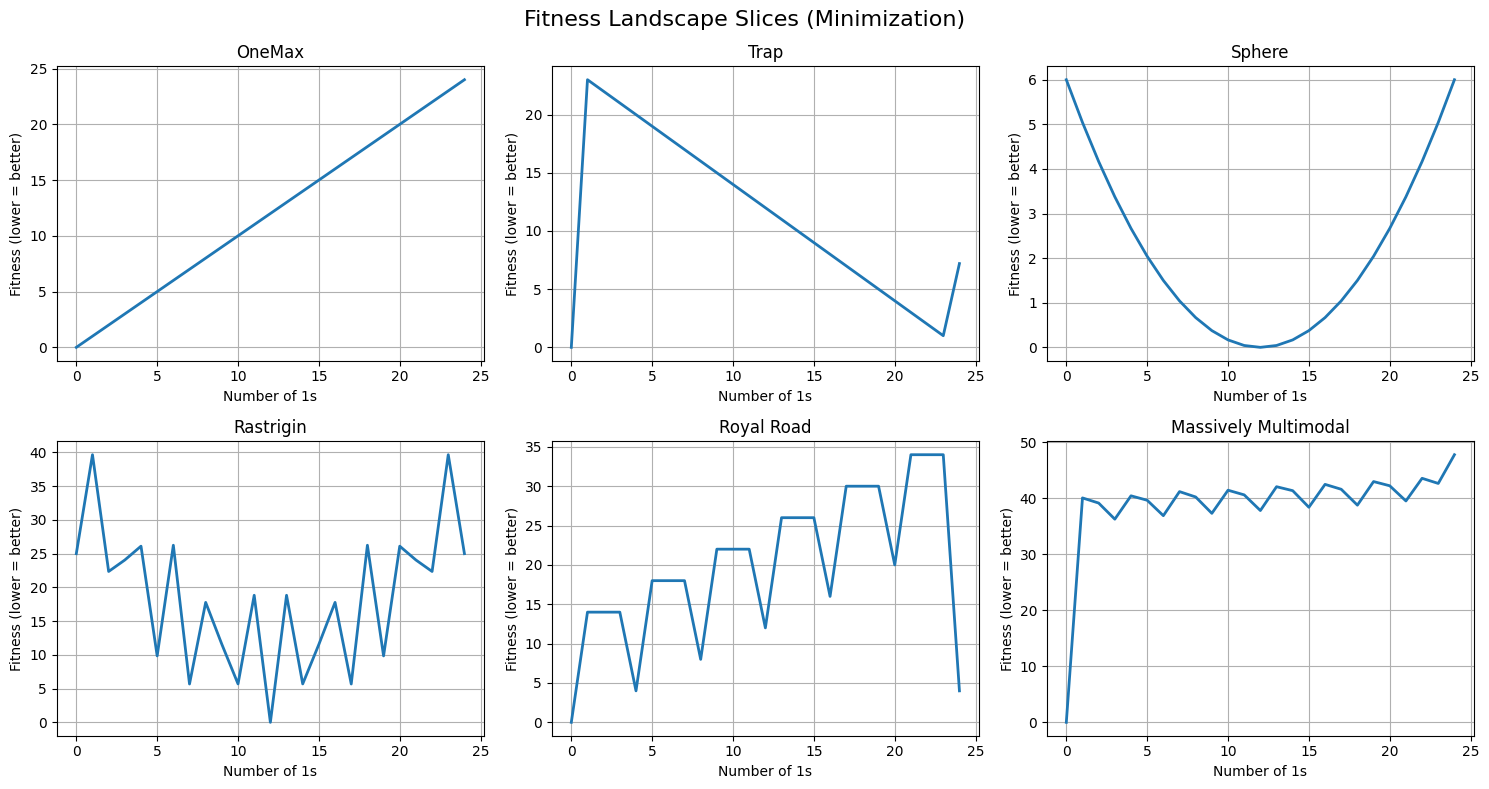

In [5]:
class DummyIndividual:
    def __init__(self, genome):
        self.genome = genome


n = 24
ones_range = np.arange(0, n + 1)

def eval_fitness(func):
    values = []
    for ones in ones_range:
        genome = np.array([1]*ones + [0]*(n - ones))
        ind = DummyIndividual(genome)
        values.append(func(ind))
    return values

fitness_functions = {
    "OneMax": onemax,
    "Trap": trap,
    "Sphere": sphere,
    "Rastrigin": rastrigin,
    "Royal Road": royal_road,
    "Massively Multimodal": massively_multimodal,
}

results = {name: eval_fitness(func) for name, func in fitness_functions.items()}


num_plots = len(results)
cols = 3
rows = int(np.ceil(num_plots / cols))

fig, axs = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axs = axs.flatten()

for ax, (name, values) in zip(axs, results.items()):
    ax.plot(ones_range, values, linewidth=2)
    ax.set_title(name)
    ax.set_xlabel("Number of 1s")
    ax.set_ylabel("Fitness (lower = better)")
    ax.grid(True)

for ax in axs[len(results):]:
    ax.axis("off")

plt.suptitle("Fitness Landscape Slices (Minimization)", fontsize=16)
plt.tight_layout()
plt.show()


In [6]:
@dataclass
class Config:
    pop_size: int = 400
    genome_length: int = 30
    mutation_rate: float = 0.15  # Higher for better exploration
    crossover_rate: float = 0.8
    max_generations: int = 300
    topology: str = 'grid'
    rewiring_prob: float = 0.1
    fitness_func: Callable = onemax
    seed: int = 42

# Setting up diffrent Topologies

In [7]:
class TopologyManager:
    def __init__(self, pop_size: int, topology: str, rewiring_prob: float, rng):
        self.pop_size = pop_size
        self.rng = rng

        if topology == 'ring':
            self.neighbors = [[(i-1) % pop_size, (i+1) % pop_size] for i in range(pop_size)]
        elif topology == 'grid':
            self.neighbors = self._build_grid()
        else:  # smallworld
            self.neighbors = self._build_smallworld(rewiring_prob)

    def _build_grid(self):
        grid_size = int(np.ceil(np.sqrt(self.pop_size)))
        neighbors = []
        for i in range(self.pop_size):
            row, col = i // grid_size, i % grid_size
            n = []
            for dr in [-1, 0, 1]:
                for dc in [-1, 0, 1]:
                    if dr == 0 and dc == 0: continue
                    nr = (row + dr) % grid_size
                    nc = (col + dc) % grid_size
                    idx = nr * grid_size + nc
                    if idx < self.pop_size: n.append(idx)
            neighbors.append(n)
        return neighbors

    def _build_smallworld(self, p):
        # Start with ring
        neighbors = [[(i-1) % self.pop_size, (i+1) % self.pop_size] for i in range(self.pop_size)]
        # Rewire
        for i in range(self.pop_size):
            for j in range(len(neighbors[i])):
                if self.rng.random() < p:
                    new = self.rng.integers(0, self.pop_size)
                    while new == i or new in neighbors[i]:
                        new = self.rng.integers(0, self.pop_size)
                    neighbors[i][j] = new
        return neighbors

# Setting up CGA class

In [8]:
import numpy as np

class CellularGA:
    def __init__(self, config):
        self.config = config
        self.rng = np.random.default_rng(config.seed)
        self.generation = 0

        # Initialize population
        self.population = [Individual(config.genome_length, self.rng)
                          for _ in range(config.pop_size)]
        for ind in self.population:
            ind.fitness = config.fitness_func(ind)

        self.topology = TopologyManager(config.pop_size, config.topology,
                                       config.rewiring_prob, self.rng)

        self.history = {'best': [], 'avg': [], 'diversity': []}
        self._update_history()

    # Slower selection: tournament of 2 random neighbors
    def _select(self, indices):
        a, b = self.rng.choice(indices, size=2, replace=False)
        return min([self.population[a], self.population[b]], key=lambda x: x.fitness).copy()

    # Random crossover cut
    def _crossover(self, p1, p2):
        child = Individual.__new__(Individual)
        cut = self.rng.integers(1, self.config.genome_length)
        child.genome = np.empty_like(p1.genome)
        child.genome[:cut] = p1.genome[:cut]
        child.genome[cut:] = p2.genome[cut:]
        return child

    def _mutate(self, ind):
        mask = self.rng.random(self.config.genome_length) < self.config.mutation_rate
        ind.genome = np.where(mask, 1 - ind.genome, ind.genome)

    def evolve(self):
        new_pop = []
        for i in range(self.config.pop_size):
            neighbors = self.topology.neighbors[i] + [i]

            p1 = self._select(neighbors)
            p2 = self._select(neighbors)

            child = self._crossover(p1, p2) if self.rng.random() < self.config.crossover_rate else p1.copy()
            self._mutate(child)
            child.fitness = self.config.fitness_func(child)

            if child.fitness < self.population[i].fitness and self.rng.random() < 0.5:
                new_pop.append(child)
            else:
                new_pop.append(self.population[i])

        self.population = new_pop
        self.generation += 1
        self._update_history()

    def _update_history(self):
        fits = [ind.fitness for ind in self.population]
        self.history['best'].append(min(fits))
        self.history['avg'].append(np.mean(fits))
        self.history['diversity'].append(np.std(fits))

    def run(self):
        for _ in range(self.config.max_generations):
            self.evolve()
        return self.history


# Functions for running experiment and plotting the Results

In [9]:
def run_experiment(fitness_func, func_name, num_trials=15):
    """Run comparison for one fitness function"""
    topologies = ['ring', 'grid', 'smallworld']
    results = []
    histories = {}

    for topo in topologies:
        print(f"  Testing {topo}...")
        topo_results = []

        for trial in range(num_trials):
            config = Config(
                topology=topo,
                fitness_func=fitness_func,
                seed=42 + trial
            )
            ga = CellularGA(config)
            history = ga.run()

            topo_results.append({
                'topology': topo,
                'final_best': history['best'][-1],
                'final_avg': history['avg'][-1],
                'final_diversity': history['diversity'][-1]
            })

            if trial == 0:
                histories[topo] = history

        results.extend(topo_results)

    return pd.DataFrame(results), histories

def plot_results(df, histories, title, plots=("convergence", "distribution", "diversity")):
    """
    plots: tuple containing any of:
        - "convergence"
        - "distribution"
        - "diversity"
    """

    plot_order = list(plots)
    num_plots = len(plot_order)

    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))

    if num_plots == 1:
        axes = [axes]

    ax_idx = 0

    if "convergence" in plot_order:
        ax = axes[ax_idx]
        for topo, hist in histories.items():
            ax.plot(hist['best'], label=topo.capitalize(), linewidth=2.5)
        ax.set_xlabel('Generation', fontweight='bold')
        ax.set_ylabel('Best Fitness (Lower = Better)', fontweight='bold')
        ax.set_title(f'{title}: Convergence', fontsize=13, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
        ax_idx += 1

    if "distribution" in plot_order:
        ax = axes[ax_idx]
        sns.boxplot(data=df, x='topology', y='final_best', ax=ax)
        ax.set_xlabel('Topology', fontweight='bold')
        ax.set_ylabel('Final Best Fitness', fontweight='bold')
        ax.set_title('Final Performance Distribution', fontsize=13, fontweight='bold')
        ax_idx += 1


    if "diversity" in plot_order:
        ax = axes[ax_idx]
        for topo, hist in histories.items():
            ax.plot(hist['diversity'], label=topo.capitalize(), linewidth=2.5)
        ax.set_xlabel('Generation', fontweight='bold')
        ax.set_ylabel('Diversity (Std Dev)', fontweight='bold')
        ax.set_title('Population Diversity', fontsize=13, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
        ax_idx += 1

    plt.tight_layout()
    plt.show()


# Experiment 1 (OneMax)

In [10]:
df1, hist1 = run_experiment(onemax, "OneMax", num_trials=15)

  Testing ring...
  Testing grid...
  Testing smallworld...


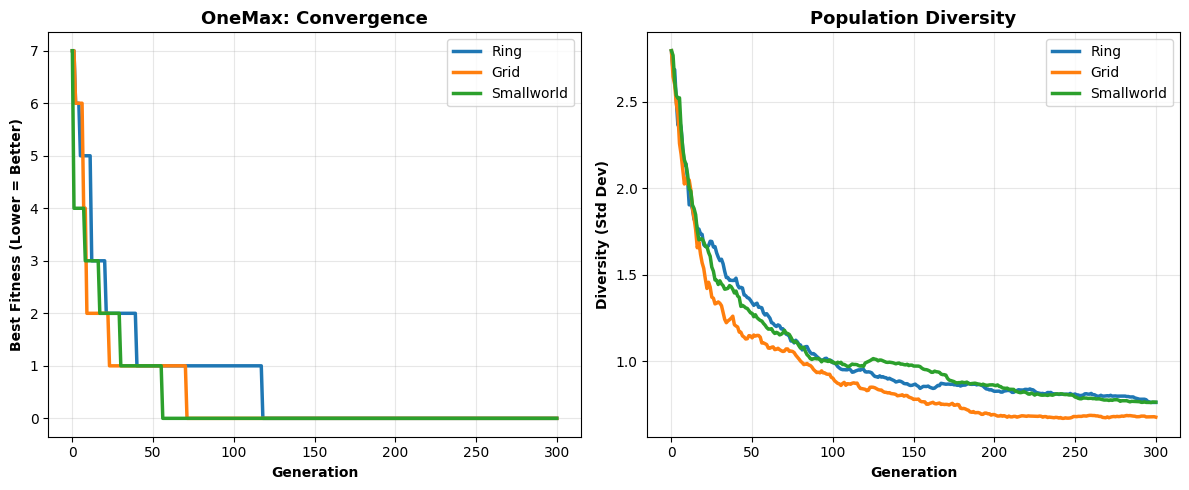

In [11]:
plot_results(df1, hist1, "OneMax" ,plots=("convergence",  "diversity"))

# Experiment 2 (Trap)

In [ ]:
df2, hist2 = run_experiment(trap, "Trap", num_trials=15)

  Testing ring...
  Testing grid...
  Testing smallworld...


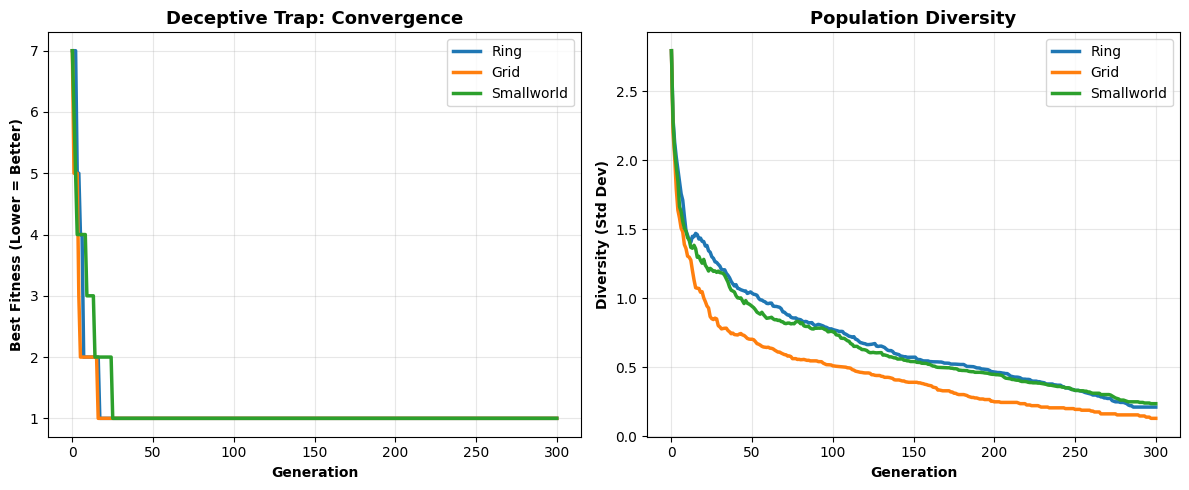

In [ ]:
plot_results(df2, hist2, "Deceptive Trap",plots=("convergence", "diversity"))

# Experiment 3 (Multimodal)

In [12]:
df3, hist3 = run_experiment(massively_multimodal, "Multimodal", num_trials=15)

  Testing ring...
  Testing grid...
  Testing smallworld...


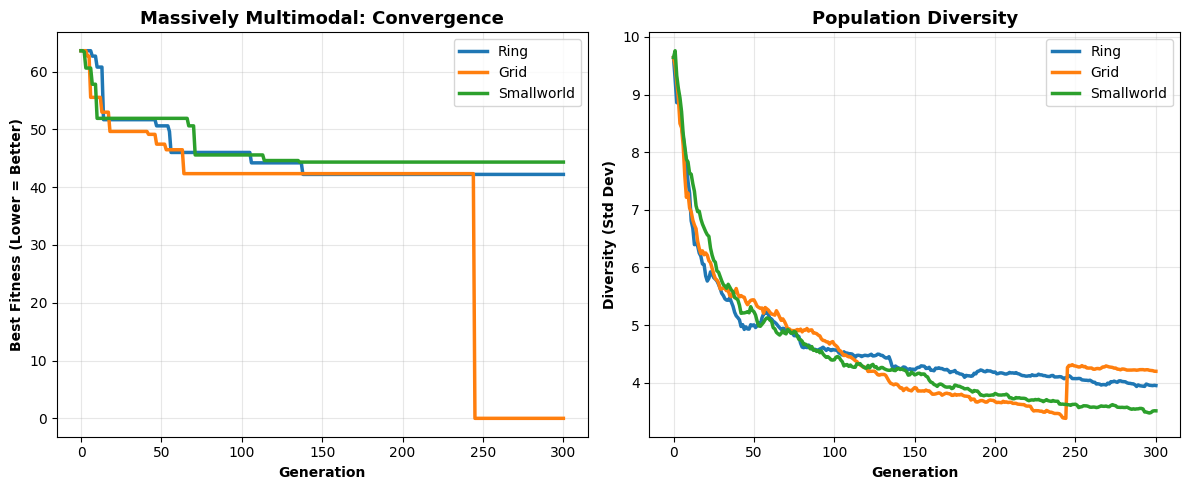

In [13]:
plot_results(df3, hist3, "Massively Multimodal", plots=("convergence", "diversity"))


# Experiment 4 (Royal-Road)

In [16]:
df5, hist5 = run_experiment(royal_road, "Royal-Road", num_trials=15)

  Testing ring...
  Testing grid...
  Testing smallworld...


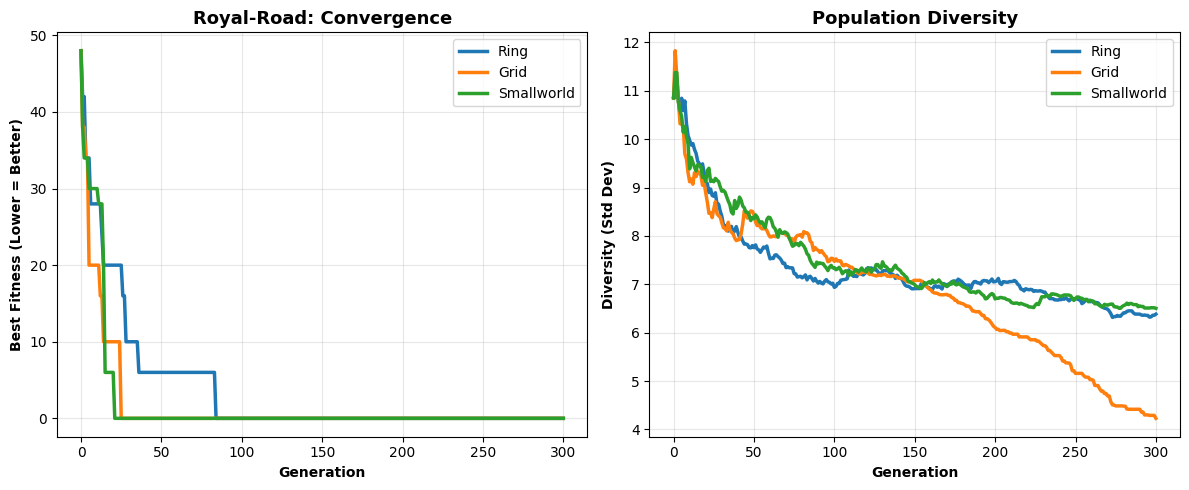

In [ ]:
plot_results(df5, hist5, "Royal-Road", plots=("convergence", "diversity"))